In [3]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, KFold
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

In [4]:
# File paths
fr = r"/Users/livalacaisse/Documents/DataScience/CO2/000-C02 First Delivery/Cleaned_countries/FR_Cleaned.csv"
de = r"/Users/livalacaisse/Documents/DataScience/CO2/000-C02 First Delivery/Cleaned_countries/Cl_no_FR/DT_Cleaned.csv"
es = r"/Users/livalacaisse/Documents/DataScience/CO2/000-C02 First Delivery/Cleaned_countries/Cl_no_FR/ES_Cleaned.csv"
it = r"/Users/livalacaisse/Documents/DataScience/CO2/000-C02 First Delivery/Cleaned_countries/Cl_no_FR/IT_Cleaned.csv"
pt = r"/Users/livalacaisse/Documents/DataScience/CO2/000-C02 First Delivery/Cleaned_countries/Cl_no_FR/PT_Cleaned.csv"

# Data types specification
dtype_spec = {
    'Em_on_target': 'int64',
    'Fuel consumption': 'float32',
    'Engine_cm3': 'float32',
    'Kg_veh': 'float32',
    'Test_mass': 'float32',
    'Power_KW': 'float32',
    'El_Consumpt_whkm': 'float32',
    'Energy': 'category',
    'Fuel_mode': 'category',
    'Brand': 'category',
    'Veh_type': 'category',
    'Veh_Model': 'category',
    'Version': 'category',
    'Veh_Category': 'category',
    'year': 'int64',
    'Country': 'category'
}

In [5]:
# Load data in chunks
def load_data_in_chunks(files, dtype_spec, chunksize=50000):
    df_list = []
    for file in files:
        for chunk in pd.read_csv(file, dtype=dtype_spec, chunksize=chunksize):
            df_list.append(chunk)
    return pd.concat(df_list, ignore_index=True)

In [6]:
# Load data
files = [fr, de, es, pt, it]
df_clean = load_data_in_chunks(files, dtype_spec)

# Filter only hybrid petrol and hybrid diesel vehicles
hybrid_df = df_clean[df_clean['Energy'].isin(['hybrid petrol', 'hybrid diesel'])]

In [7]:
# Define features for hybrid vehicles
features = ['Engine_cm3', 'Axle_width_other_mm', 'Axle_width_steer_mm', 'Fuel consumption', 
            'El_Consumpt_whkm', 'Power_KW', 'Electric range (km)', 'year', 'Wheelbase_mm', 
            'Eco-innovation program', 'Test_mass', 'Kg_veh']

# Prepare the data
X = hybrid_df[features]
y = hybrid_df['CO2_wltp']

In [8]:
# Log transformation to address skewness
X_log = np.log1p(X)
y_log = np.log1p(y)

In [9]:
# Standard scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_log)

In [10]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_log, test_size=0.2, random_state=42)

In [52]:
# Random Forest Regression
rf = RandomForestRegressor()

In [53]:
# Parameter grid for RandomizedSearchCV
param_grid = {
    'n_estimators': [100, 300, 500],
    'max_features': ['sqrt', 'log2', None],
    'max_depth': [10, 30, 50, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

In [54]:
# Cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [55]:
# RandomizedSearchCV
random_search = RandomizedSearchCV(rf, param_distributions=param_grid, n_iter=50, cv=kf, random_state=42, n_jobs=-1)
random_search.fit(X_train, y_train)

/opt/anaconda3/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


RandomizedSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=RandomForestRegressor(), n_iter=50, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 30, 50, None],
                                        'max_features': ['sqrt', 'log2', None],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 300, 500]},
                   random_state=42)

In [56]:
# Best model
best_rf = random_search.best_estimator_

In [57]:
# Predictions with best model
y_pred_best = best_rf.predict(X_test)

In [58]:
# Inverse log transformation for evaluation
y_test_exp = np.expm1(y_test)
y_pred_best_exp = np.expm1(y_pred_best)

In [59]:
# Function to calculate RMSE
#def root_mean_squared_error(y_true, y_pred):
#    return np.sqrt(mean_squared_error(y_true, y_pred))

In [60]:
# Evaluation of best model
best_r2 = r2_score(y_test_exp, y_pred_best_exp)
mse_best = mean_squared_error(y_test_exp, y_pred_best_exp)
rmse_best = np.sqrt(mse_best)

In [61]:
# Best model
best_rf = random_search.best_estimator_
best_params = random_search.best_params_

In [62]:
# Cross-validated R^2
cv_r2 = cross_val_score(best_rf, X_scaled, y_log, cv=kf, scoring='r2').mean()

In [63]:
# Results reporting
print(f"Best R^2 Score: {best_r2}")
print(f"Mean Squared Error: {mse_best}")
print(f"RMSE: {rmse_best}")
print(f"Cross-validated R^2: {cv_r2}")
print(f"Best Parameters: {best_params}")

Best R^2 Score: 0.9986065384470275
Mean Squared Error: 0.34526575267585
RMSE: 0.5875931863762973
Cross-validated R^2: 0.9993282911658923
Best Parameters: {'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': True}


In [72]:
# Save the best model
joblib.dump(best_rf, "best_hybrid_rf_model.joblib")
print("Model saved as best_hybrid_rf_model.joblib")

Model saved as best_hybrid_rf_model.joblib


Text(0.5, 1.0, 'Regression Results for Hybrid Vehicles')

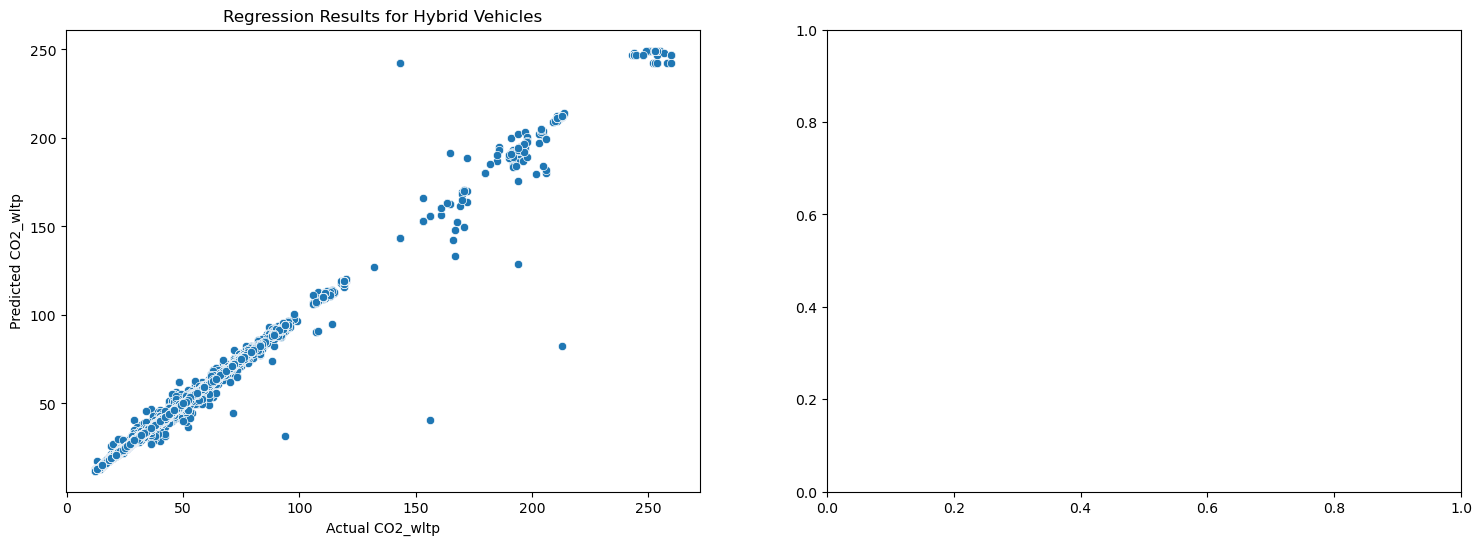

In [65]:
# Visualization
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Scatter plot of actual vs predicted for best model
sns.scatterplot(x=y_test_exp, y=y_pred_best_exp, ax=axes[0])
axes[0].set_xlabel('Actual CO2_wltp')
axes[0].set_ylabel('Predicted CO2_wltp')
axes[0].set_title('Regression Results for Hybrid Vehicles')

In [66]:
# Feature importances
importances = best_rf.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = X.columns

# Plot feature importances
sns.barplot(x=importances[indices], y=feature_names[indices], ax=axes[1])
axes[1].set_title('Feature Importances')
axes[1].set_xlabel('Importance')
axes[1].set_ylabel('Feature')

plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

In [67]:
hybrid_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1388293 entries, 73794 to 27611380
Data columns (total 25 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   Unnamed: 0              1388293 non-null  int64  
 1   Country                 1388293 non-null  object 
 2   Constructor             1388293 non-null  object 
 3   Veh_type                1388293 non-null  object 
 4   Version                 1388293 non-null  object 
 5   Brand                   1388293 non-null  object 
 6   Veh_Model               1388293 non-null  object 
 7   Veh_Category            1388293 non-null  object 
 8   Kg_veh                  1388293 non-null  float32
 9   Test_mass               1388293 non-null  float32
 10  CO2_wltp                1388293 non-null  float64
 11  Wheelbase_mm            1388293 non-null  float64
 12  Axle_width_steer_mm     1388293 non-null  float64
 13  Axle_width_other_mm     1388293 non-null  float64
 14  En